## Importing Libraries

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram,linkage,cophenet
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
import nbformat
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True)

In [59]:
# Read the Data

df=pd.read_csv('Country-data.csv')

In [60]:
# Make the country as index

df.set_index('country',inplace=True)

In [61]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Data Exploration

In [62]:
print("No of Countries",df.shape[0])

No of Countries 167


In [63]:
# see the five point summary

df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Infrence from Five point summary

* Gdp,Inflation,Income,imports Have some outliers


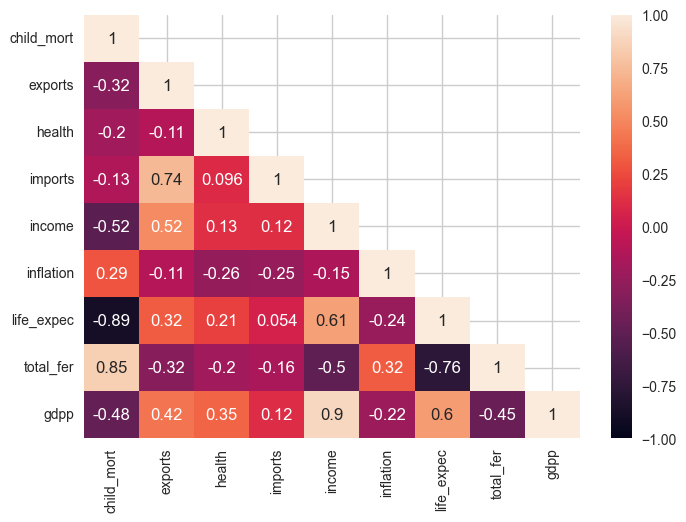

In [64]:
# Lets look the correlation Plot

sns.heatmap(df.corr(),vmax=1,vmin=-1,annot=True,mask=np.triu(df.corr(),k=1))
plt.show()

### Univariate Analysis

In [65]:
cols=df.columns

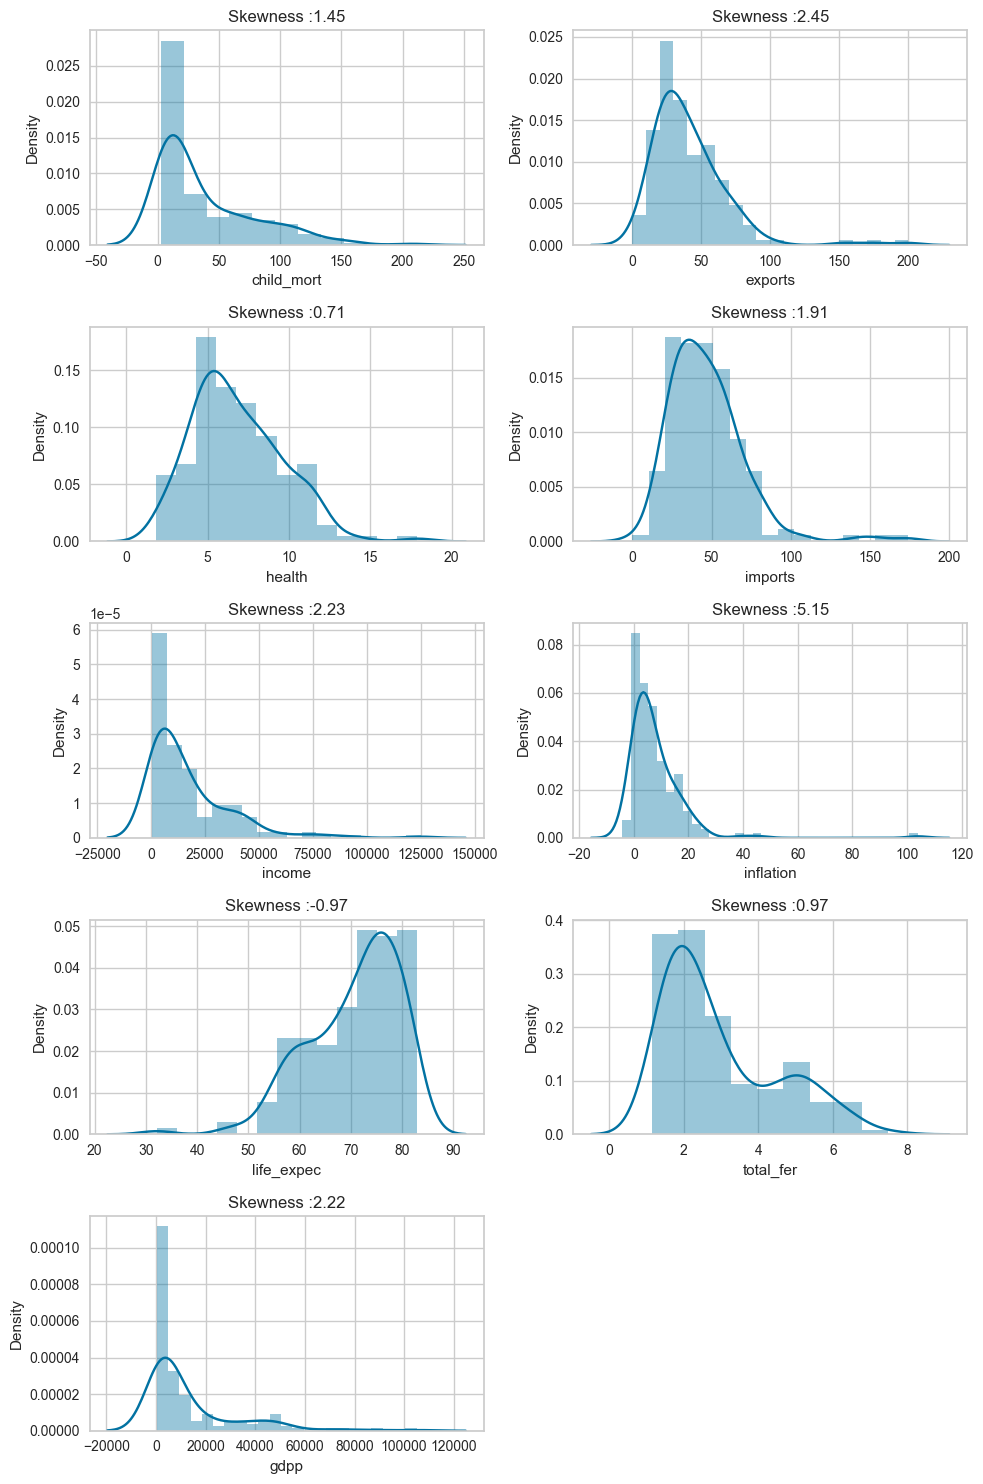

In [66]:
t=1
plt.figure(figsize=(10,15))
for i in cols:
    plt.subplot(5,2,t)
    sns.distplot(df[i])
    plt.title(f"Skewness :{round(df[i].skew(),2)}")
    t+=1
plt.tight_layout()
plt.show()

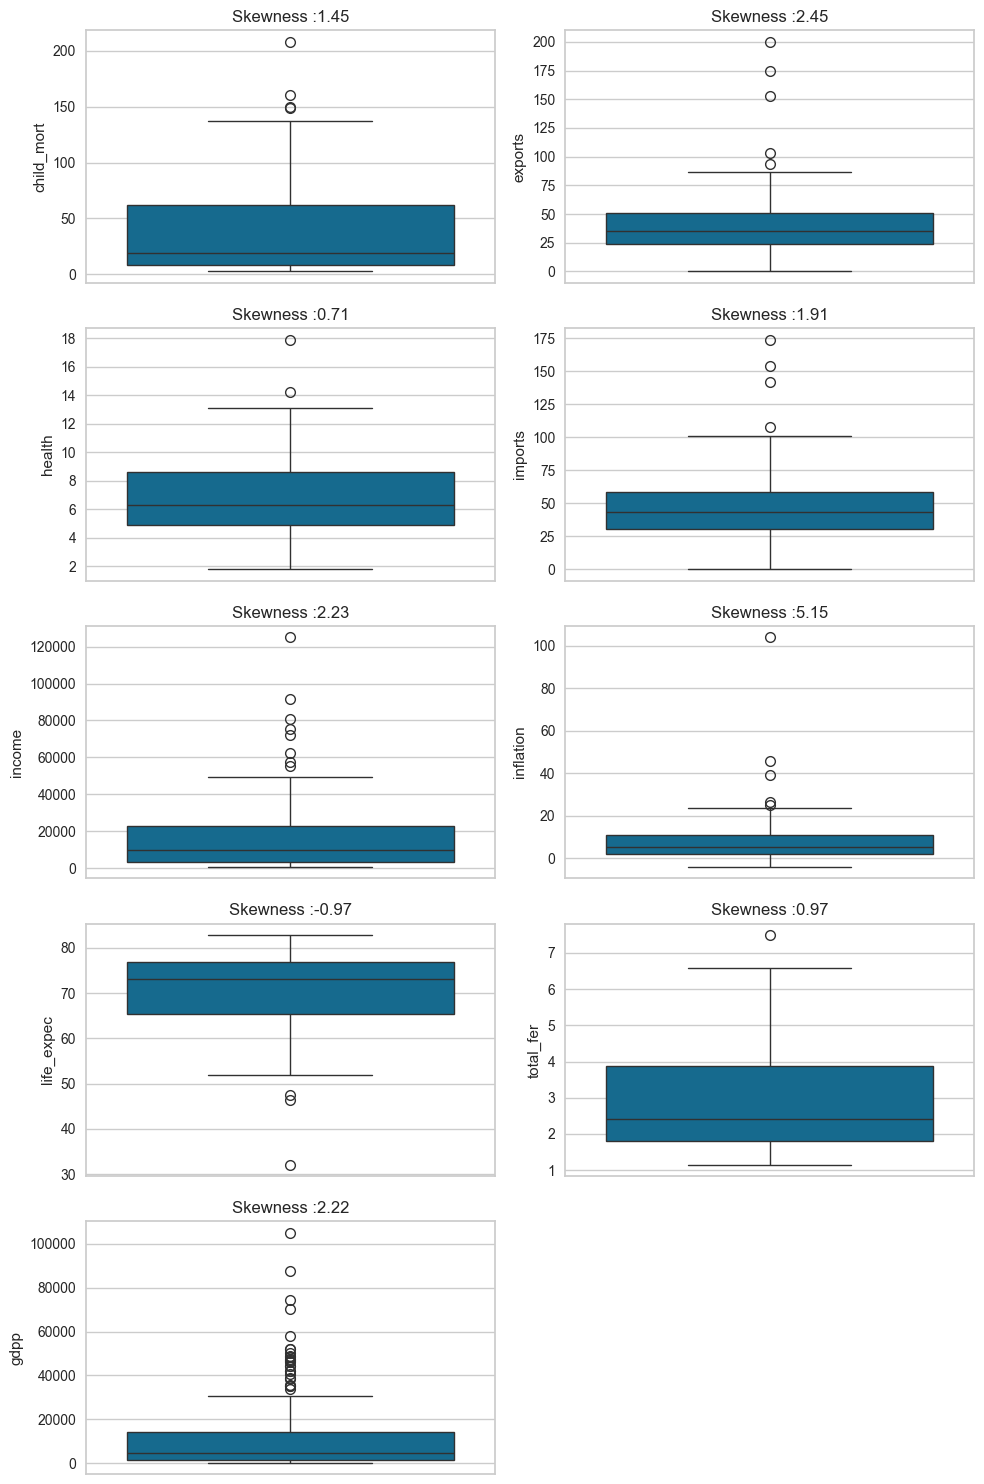

In [67]:
t=1
plt.figure(figsize=(10,15))
for i in cols:
    plt.subplot(5,2,t)
    sns.boxplot(df[i])
    plt.title(f"Skewness :{round(df[i].skew(),2)}")
    t+=1
plt.tight_layout()
plt.show()

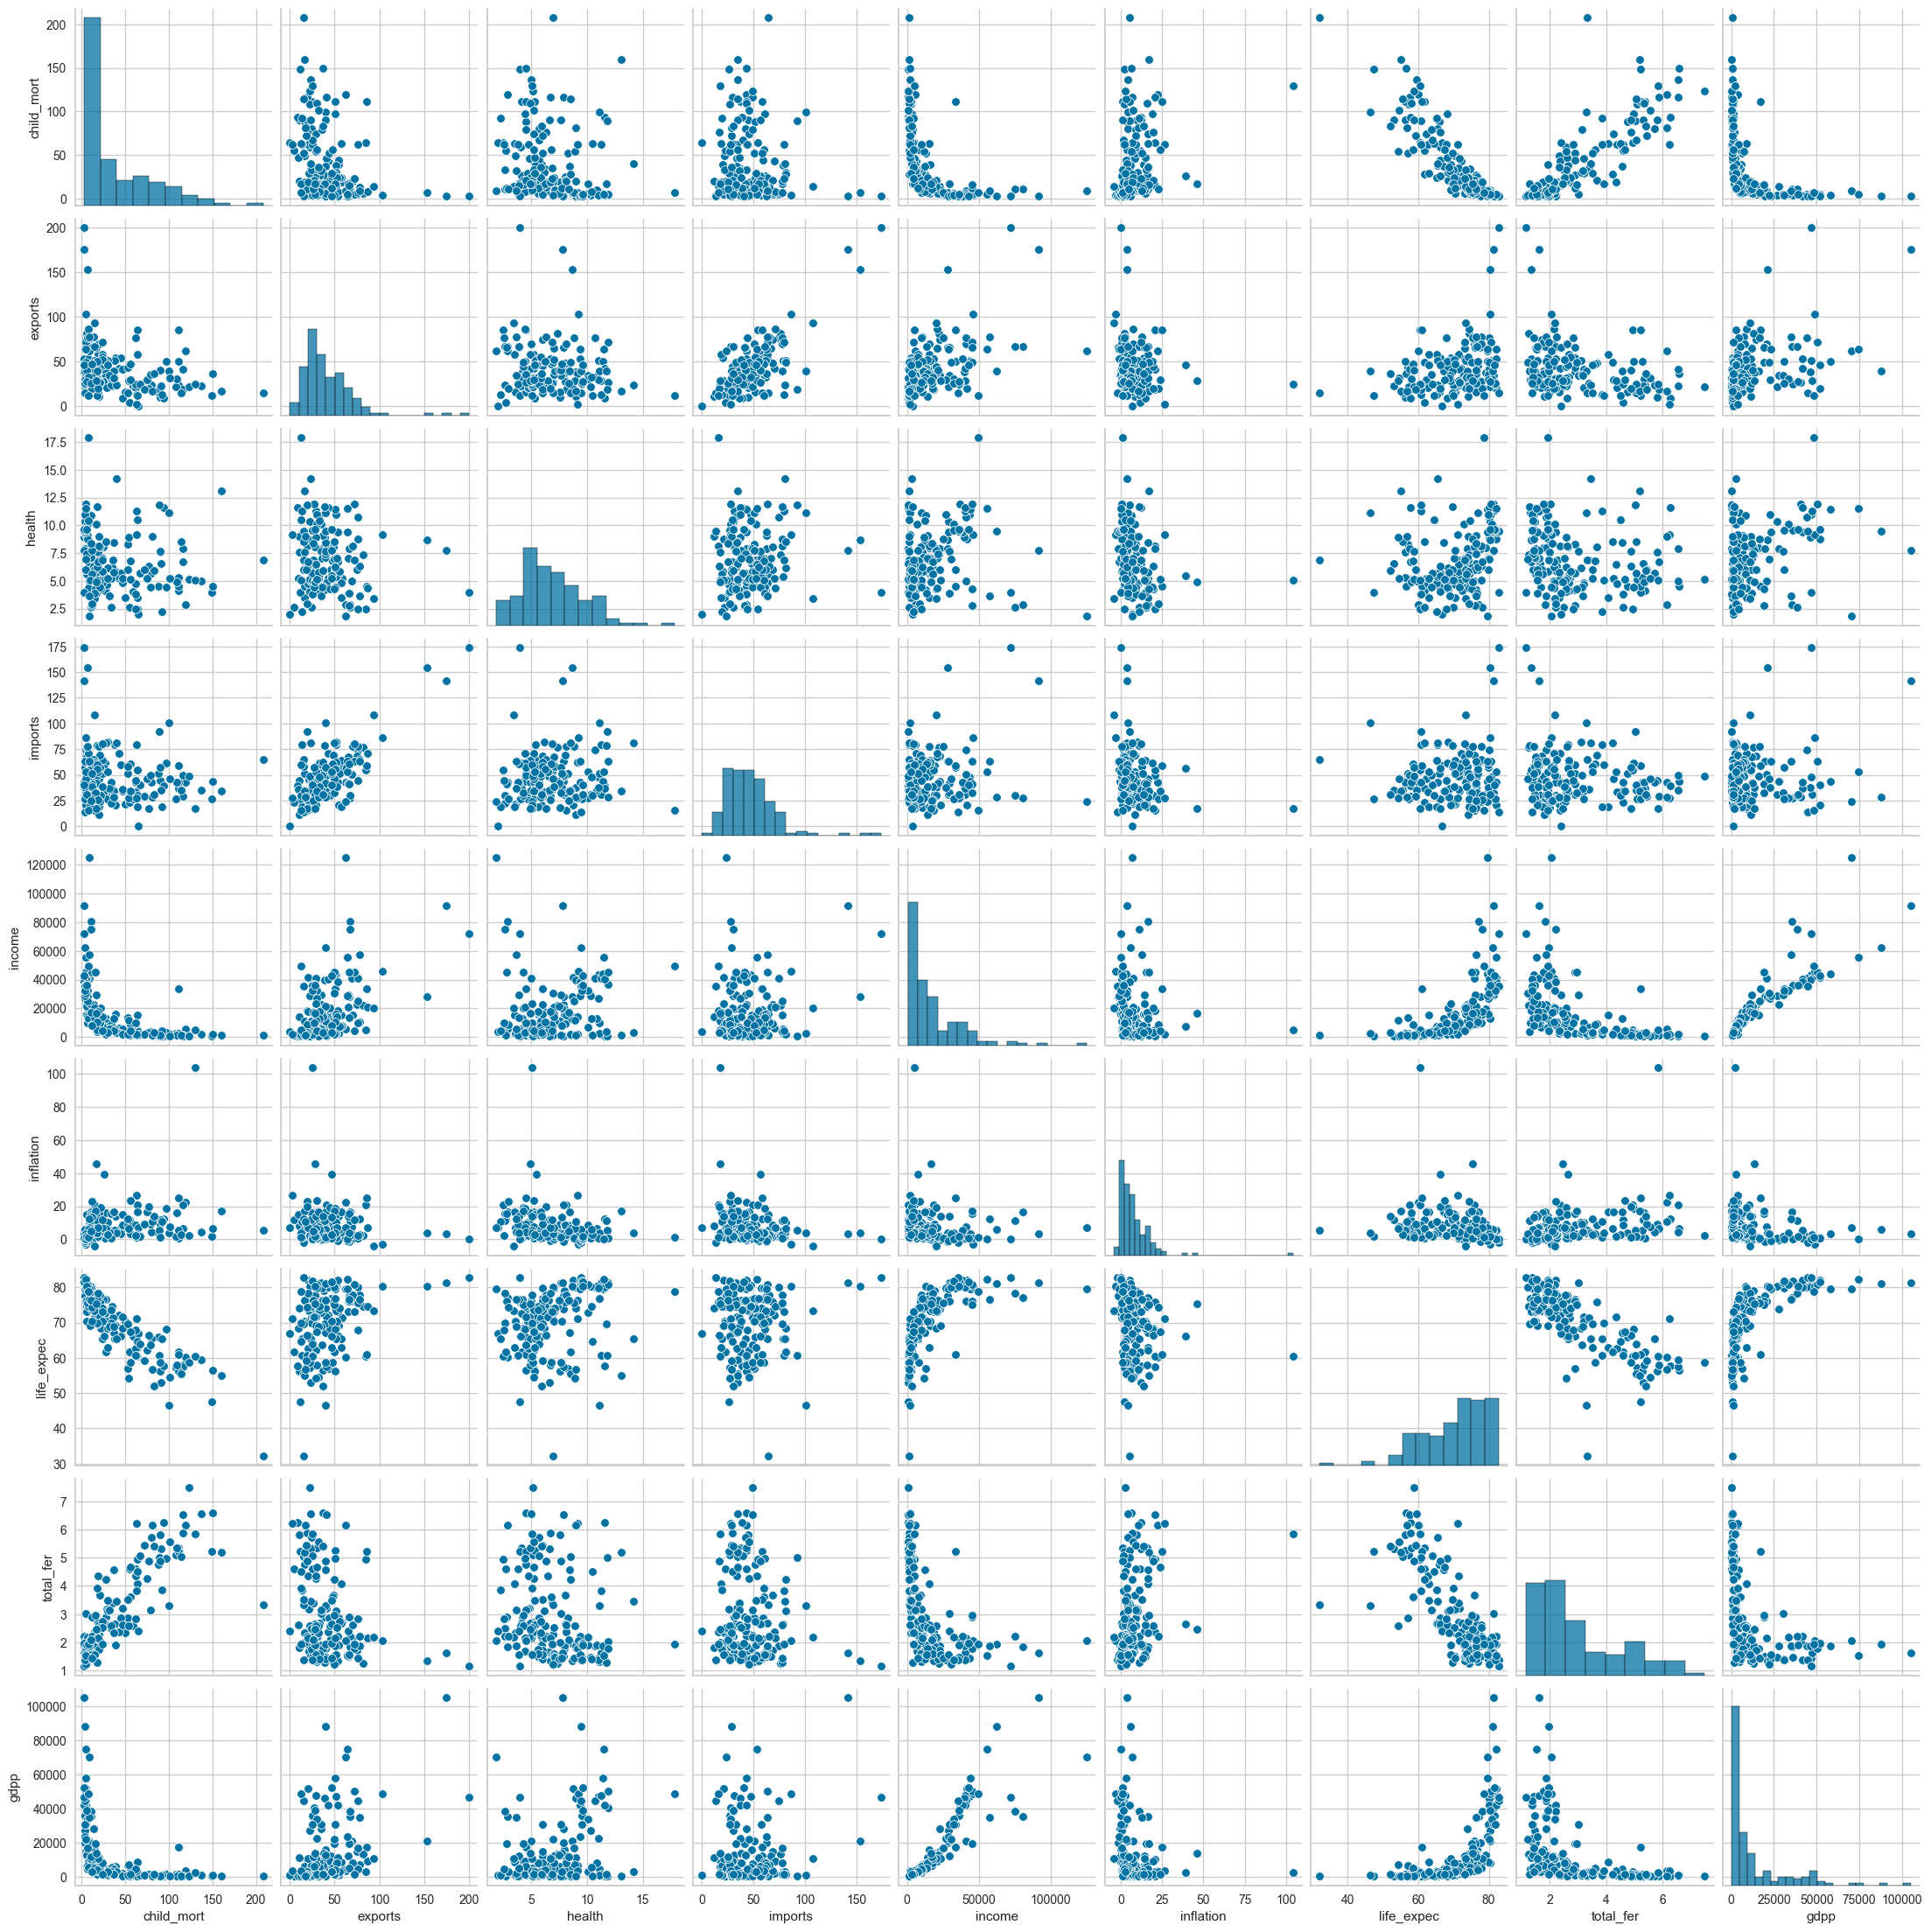

In [68]:
sns.pairplot(df)
plt.show()

In [69]:
# Check for missing value

df.isnull().sum().sum()

0

In [70]:
# Check for Duplicated Data

df.duplicated().sum()

0

In [71]:
# Treat the outliers (Capping wth iqr)

for i in cols:
    q3,q1=np.percentile(df[i],(75,25))
    iqr=q3-q1
    ul=q3+1.5*iqr
    ll=q1-1.5*iqr
    df[i]=df[i].apply(lambda x:ul if x>ul else ll if x<ll else x)
    

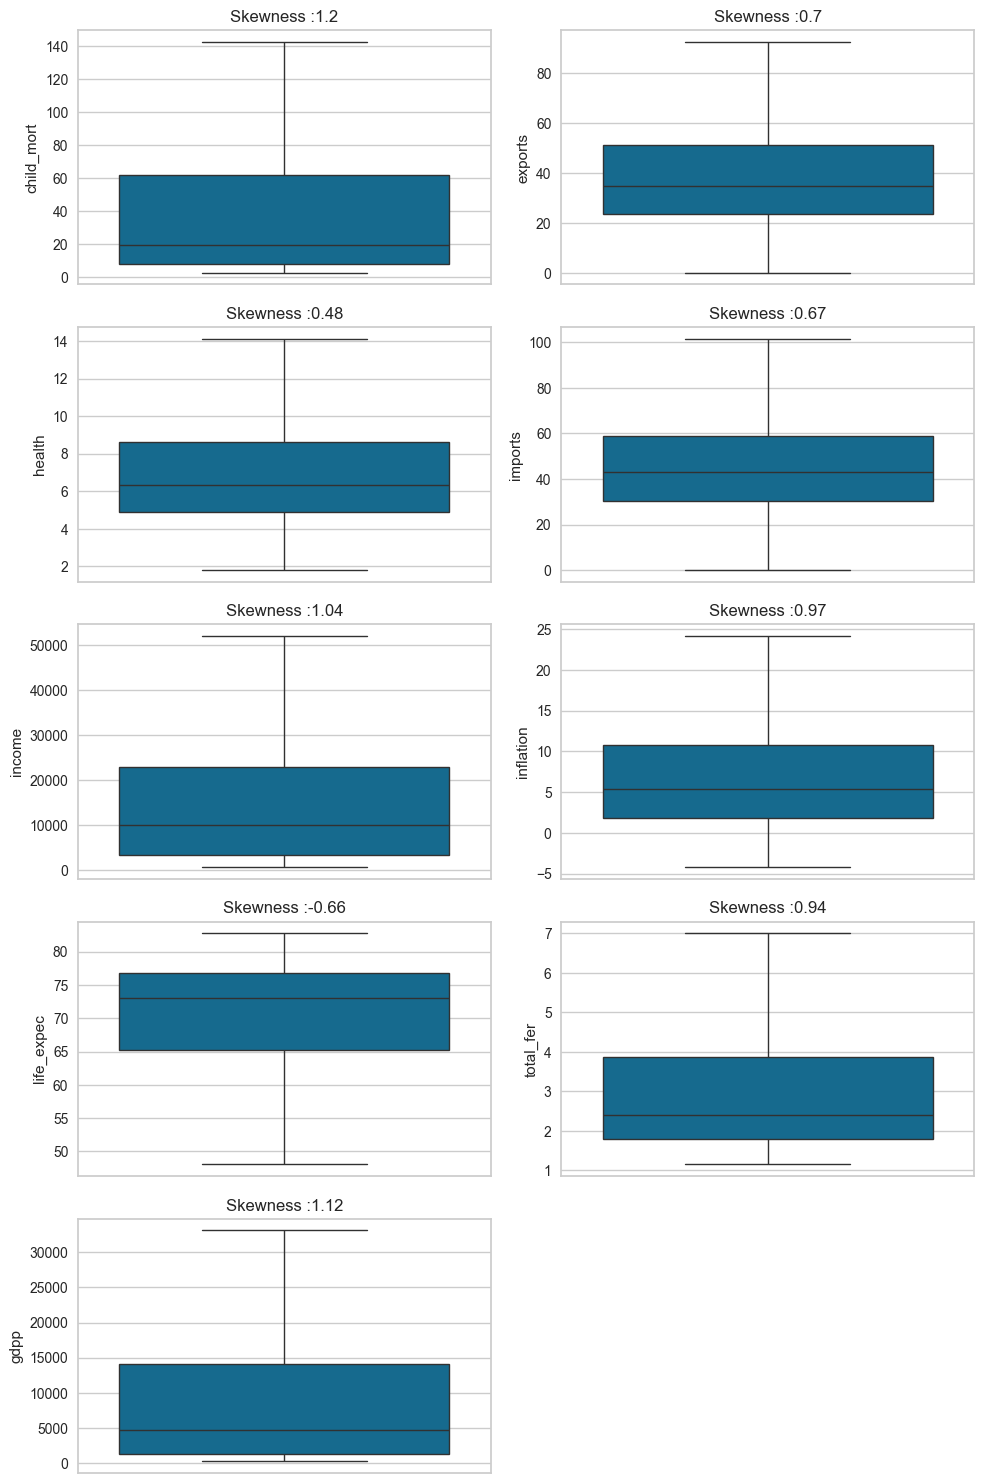

In [72]:
# Check for outliers after capping

t=1
plt.figure(figsize=(10,15))
for i in cols:
    plt.subplot(5,2,t)
    sns.boxplot(df[i])
    plt.title(f"Skewness :{round(df[i].skew(),2)}")
    t+=1
plt.tight_layout()
plt.show()

We will use scaled data for Clustering

In [73]:
sc=StandardScaler()


In [74]:
df_s=sc.fit_transform(df)
df_s=pd.DataFrame(df_s,columns=cols,index=df.index)

In [75]:
df_s

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.369802,-1.391107,0.296013,-0.047444,-0.943936,0.355270,-1.702225,1.915276,-0.846341
Albania,-0.550464,-0.543547,-0.091190,0.135021,-0.395181,-0.385208,0.663321,-0.862779,-0.540827
Algeria,-0.271295,-0.053846,-0.985893,-0.713196,-0.199291,1.351551,0.686859,-0.036691,-0.508868
Angola,2.121210,1.071524,-1.482114,-0.146074,-0.660984,2.293979,-1.243238,2.141784,-0.589198
Antigua and Barbuda,-0.714835,0.280469,-0.286671,0.642965,0.209637,-0.841463,0.722166,-0.543003,0.159686
...,...,...,...,...,...,...,...,...,...
Vanuatu,-0.221723,0.332264,-0.579893,0.337212,-0.855555,-0.664945,-0.901941,0.369691,-0.637569
Venezuela,-0.537419,-0.520004,-0.707708,-1.393742,0.038151,2.557260,0.557401,-0.316495,0.271975
Vietnam,-0.375657,1.528265,0.017828,1.693373,-0.753982,0.753184,0.286717,-0.662919,-0.780954


## PCA (Principal Component Analysis)

For better cluster and better visualization

In [76]:
pca=PCA(n_components=9)

In [77]:
pca.fit(df_s)

PCA(n_components=9)

In [78]:
# Lets use the % of explained variance to decide the no of PC's

pca.explained_variance_ratio_


array([0.48892383, 0.16452848, 0.13756787, 0.09504553, 0.0650032 ,
       0.02011842, 0.01655859, 0.00899467, 0.00325941])

In [79]:
# Lets take 95% varinace for that we consider 5 PC's

pca_final=PCA(n_components=5)
pca_data=pca_final.fit_transform(df_s)

In [80]:
pca_data=pd.DataFrame(pca_data,columns=['PC1','PC2','PC3','PC4','PC5'],index=df.index)

In [81]:
pca_data

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.177917,-0.251292,1.011474,0.778804,-0.014102
Albania,0.434979,-0.218700,0.292591,-1.391241,0.156711
Algeria,-0.416784,-0.613870,-1.637859,-0.615021,0.536604
Angola,-3.306409,1.066649,-2.151219,1.698677,0.160551
Antigua and Barbuda,1.253246,0.547778,0.136955,-0.716890,-0.394628
...,...,...,...,...,...
Vanuatu,-0.882087,0.945856,0.227550,-0.680105,-0.551247
Venezuela,-0.240053,-1.742315,-2.238331,-0.080500,1.318475
Vietnam,0.305579,2.152785,-0.455745,-0.746171,1.383759


## Clustering

#### K-Means Clustering

In [82]:
# lets Identify the value of K

# Elbow Plot

kelbow = KElbowVisualizer(KMeans(),k=10)

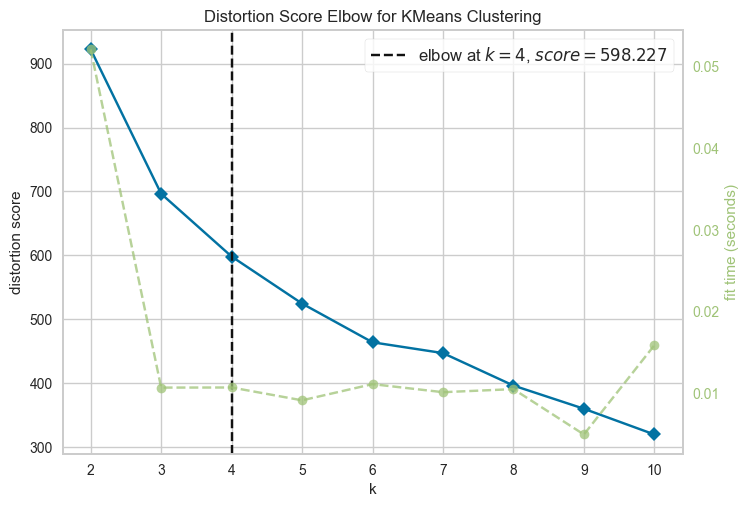

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
kelbow.fit(pca_data)
kelbow.show()

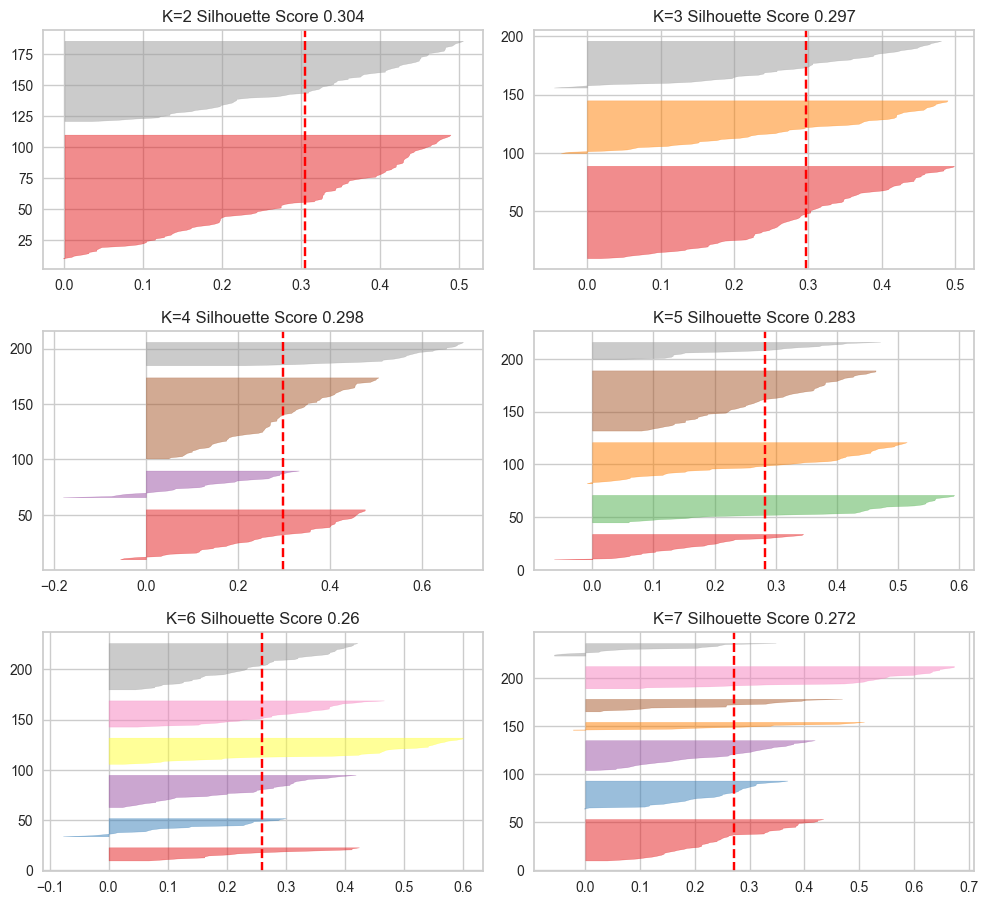

In [84]:
# Silhouette Visualizer 
t=1
plt.figure(figsize=(10,15))
for i in range(2,8):
    plt.subplot(5,2,t)
    model=KMeans(n_clusters=i)
    sil_viz=SilhouetteVisualizer(model)
    t=t+1
    sil_viz.fit(pca_data)
    plt.title(f"K={i} Silhouette Score {round(sil_viz.silhouette_score_,3)}")
plt.tight_layout()
plt.show()

**Lets go with K=2**

Reason
* Better Silhouette Score
* Better Density in Cluster
* No Outliers


**Lets also try for k = 3**

Reason
* Although there is no outliers in k=2 but some significant cluster can be created with k = 3
* With k=3 we will have 1 more cluster in between which wll be a subcluster of 2 cluster


In [85]:
kmeans = KMeans(n_clusters=3,random_state=4)
kmeans_label=kmeans.fit_predict(pca_data)

<Axes: ylabel='count'>

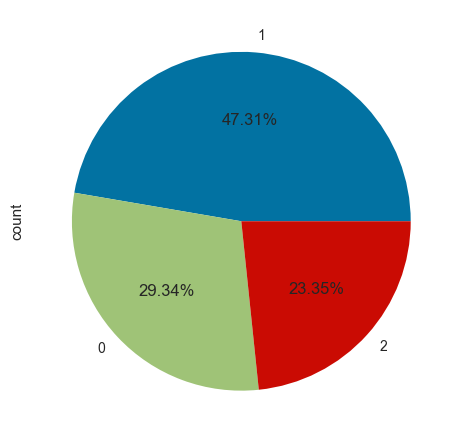

In [86]:
pd.Series(kmeans_label).value_counts().plot(kind='pie',autopct='%.2f%%')

In [87]:
centroid=kmeans.cluster_centers_

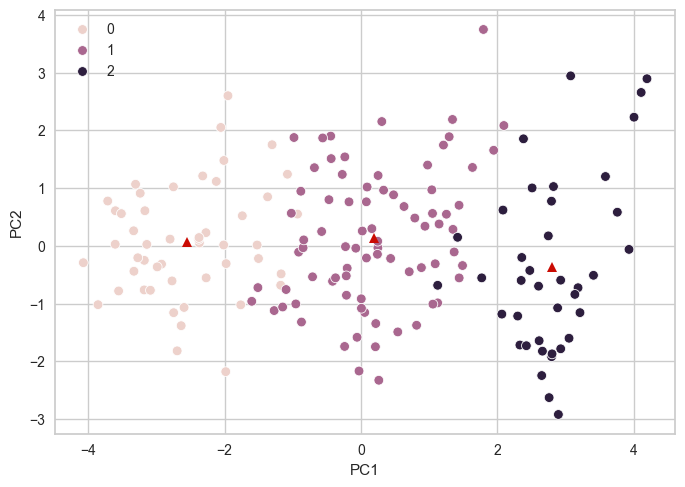

In [88]:
# visualize the Cluster

sns.scatterplot(x=pca_data['PC1'],y=pca_data['PC2'],hue=kmeans_label)
for i in range(3):
    plt.plot(centroid[i][0],centroid[i][1],marker='^',color='r')

### Aggloromative Clustering

In [89]:
# Lets make Distance and Linkage Matrix

dist_mat = euclidean_distances(pca_data)
link_mat=linkage(pca_data,method='ward')

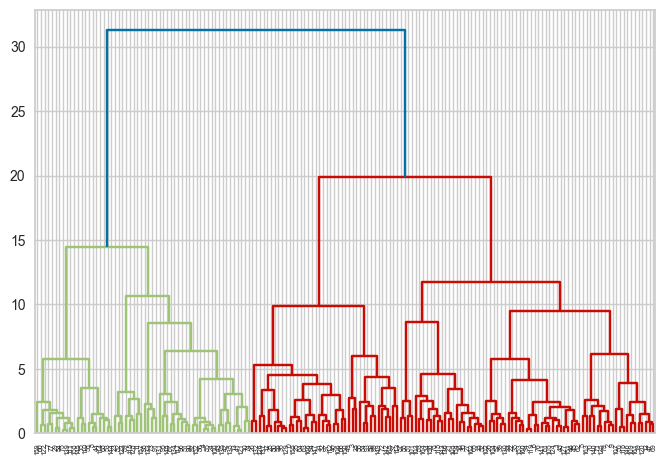

In [90]:
dendrogram(link_mat)
plt.show()

**We can go with wards linkage methord with k =2**


In [91]:
agglo=AgglomerativeClustering(linkage='ward')
agglo_labels=agglo.fit_predict(pca_data)
print("Silhouette Score :",round(silhouette_score(pca_data,agglo_labels),3))

Silhouette Score : 0.303


<Axes: xlabel='PC1', ylabel='PC2'>

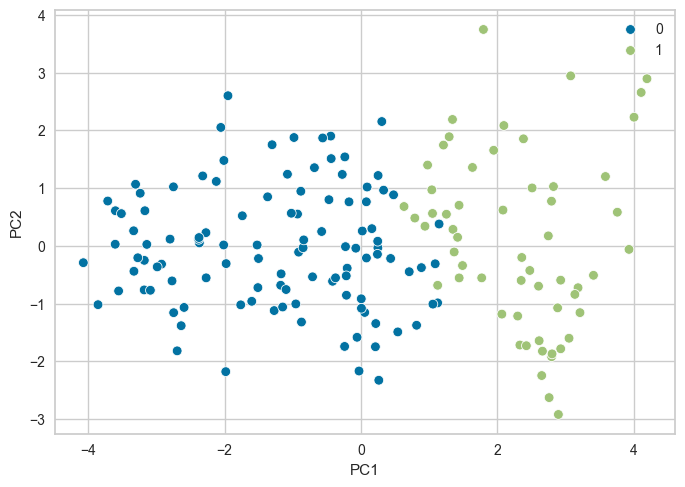

In [92]:
sns.scatterplot(x=pca_data['PC1'],y=pca_data['PC2'],hue=agglo_labels)

### Final Model & Business Interpretation

**Both the Algo gives the same score.K-Means cluster ive k=3 while aggloraomative give k=2 we need to decide which clusturing model we should go with. Lets go with K-Means as aggloromative is better for hierarchial data, While data has no such Hierarchy**

In [93]:
df['labels']=kmeans_label

In [94]:
df.groupby(by='labels')[cols].mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
labels,,,,,,,,,
0,89.602041,28.267735,6.290000,41.793182,3900.469388,10.235612,59.923469,4.914643,1879.142857
1,21.315190,40.684241,6.302532,48.161709,11572.658228,6.958848,72.848101,2.280886,6032.101266
2,5.671795,51.400000,8.416667,46.316026,39834.358974,3.296718,79.733333,1.815897,29744.871795


In [95]:
df['labels']=df['labels'].map({0:'Under Developed',2:'Developed',1:'Developing'})

**Business Interpretation**

**Infrence**

* 2 - Has lowest Child_mort than 0 and 1 has highest child_mort
* % of GDP is exports is highest for 2 and lowest for 1 while 0 has average exports
* Health index for 2 is clearly better than 11 and 2 both

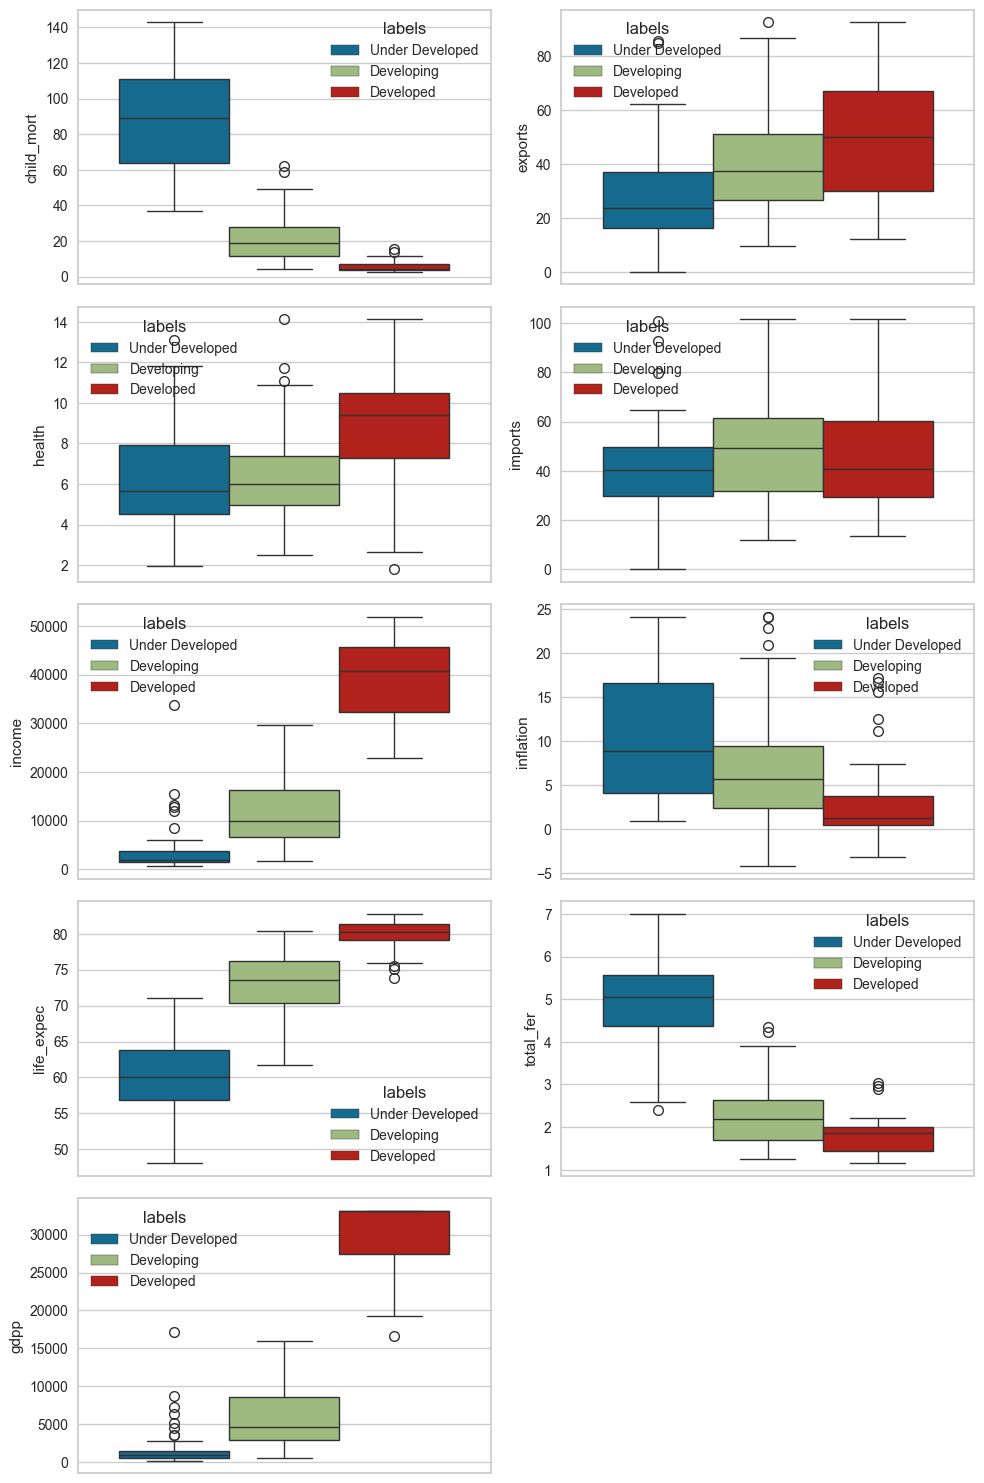

In [96]:
# Lets Visualize these Classes
t=1
plt.figure(figsize=(10,15))
for i in cols:
    plt.subplot(5,2,t)
    sns.boxplot(data=df,y=i,hue='labels')
    t=t+1

plt.tight_layout()
plt.show()


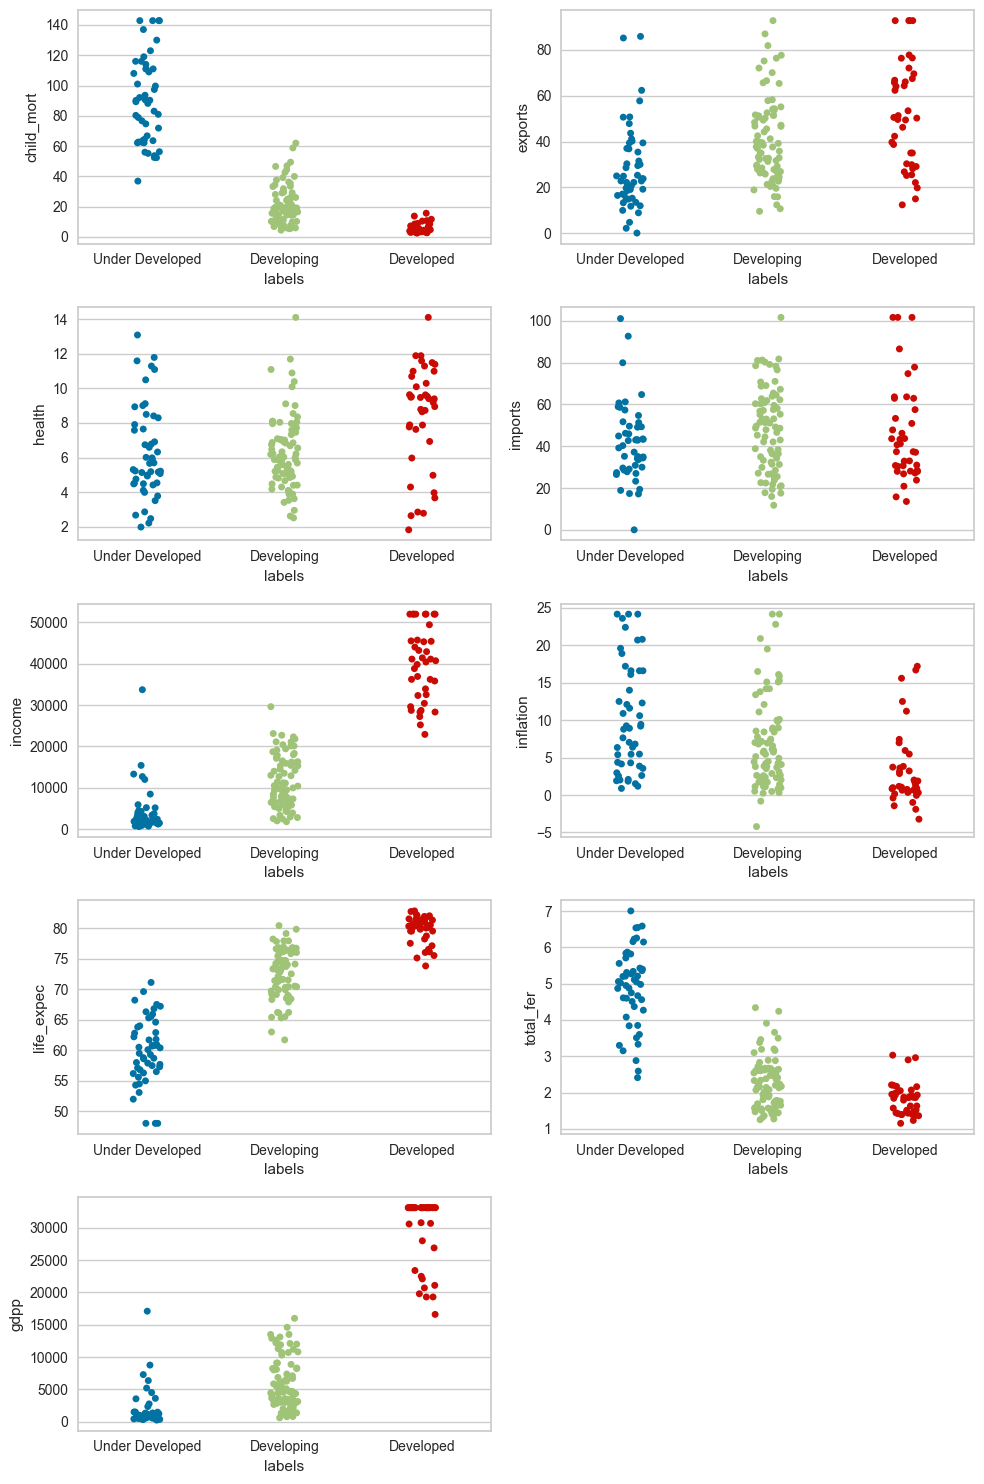

In [97]:
# Lets Visualize these Classes
t=1
plt.figure(figsize=(10,15))
for i in cols:
    plt.subplot(5,2,t)
    sns.stripplot(data=df,y=i,x='labels',hue='labels')
    t=t+1

plt.tight_layout()
plt.show()


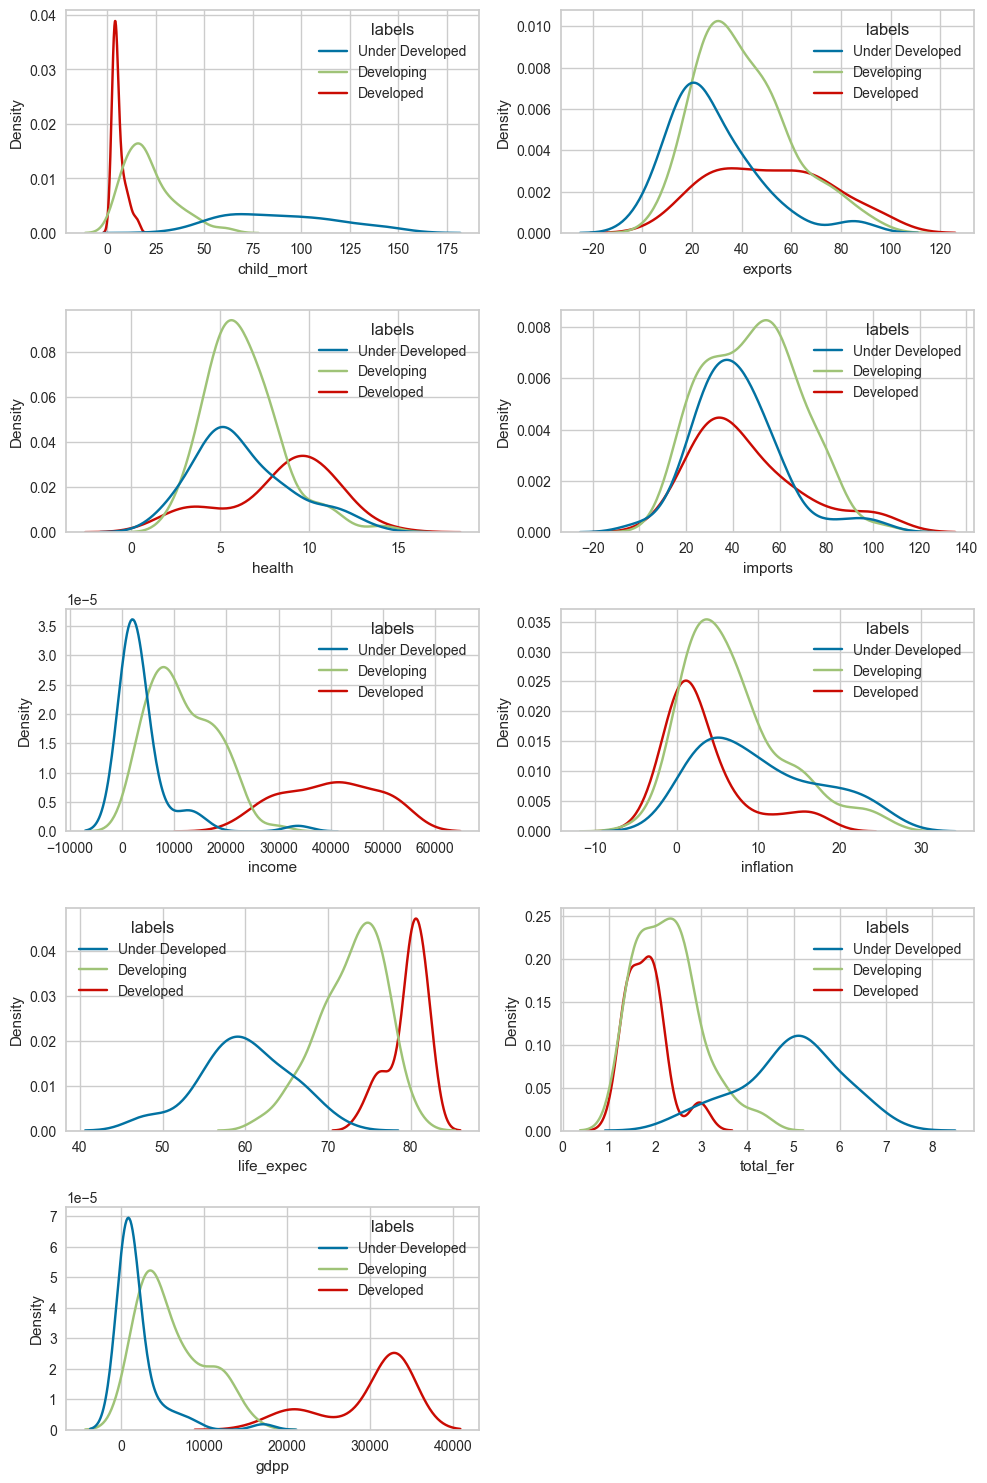

In [98]:
# Lets Visualize these Classes
t=1
plt.figure(figsize=(10,15))
for i in cols:
    plt.subplot(5,2,t)
    sns.kdeplot(data=df,x=i,hue='labels')
    t=t+1

plt.tight_layout()
plt.show()


In [99]:
df[df['labels']=='Developing'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
       'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Serbia', 'Seychelles', 'Solomon Islands',
       'Sri Lanka', 'St. Vincent and the Grenadines', 'Suriname', 'Thailand',
       'Tonga', 'Tunisia', 'Turkey

In [100]:
df[df['labels']=='Under Developed'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
       'Sierra Leone', 'South Africa', 'Sudan', 'Tajikistan', 'Tanzania',
       'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype='object', name='country')

In [101]:
df[df['labels']=='Developed'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Oman', 'Portugal', 'Qatar', 'Saudi Arabia', 'Singapore',
       'Slovak Republic', 'Slovenia', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'United Arab Emirates', 'United Kingdom',
       'United States'],
      dtype='object', name='country')

#### Visualisation on World Map

In [102]:
import plotly.express as px

In [103]:
world_data=pd.DataFrame({'Label':df['labels']})
world_data.reset_index(inplace=True)

In [104]:
fig = px.choropleth(
    data_frame=world_data,
    locationmode='country names',
    locations='country',
    color='Label',
    color_discrete_map={'Developed': 'pink', 'Under Developed': 'lightblue', 'Developing': 'lightgreen'}
)

fig.update_geos(projection_type='natural earth')
fig.update_layout(title='Country Development Classification')
fig.show()